<a href="https://colab.research.google.com/github/krisnafr/fp-vi/blob/master/FP_Visualisasi_Informasi_05211640000020_05211640000092.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project Visualisasi Informasi***

> Team: Krisna Fawwastaqi Raheko (0020) & Muslikh Annur Meiviananda (0092)

> Dataset: Goodreads Books

> Dataset ini disediakan oleh akun Kaggle bernama Soumik (jealousleopard) dengan judul “Goodreads-books comprehensive list of all books listed in goodreads” yang terakhir diperbarui pada 14 Juni 2019. Akun tersebut mendapatkan data dari API yang disediakan goodreads yaitu situs jaringan sosial tentang katalogisasi buku dimana pengguna dapat saling berbagi rekomendasi buku bacaan dengan memberikan review maupun komentar. Dataset ini dapat diambil dari link (https://www.kaggle.com/jealousleopard/goodreadsbooks).


#**Install Module**


In [45]:
!pip install isbnlib
!pip install newspaper3k
!pip install goodreads_api_client

#**Import Libraries**

In [0]:
from newspaper import Article #Digunakan ntuk Webcrawl
from progressbar import ProgressBar #Digunakan ntuk Visual Loading
from pylab import plot #Digunakan untuk Show
from wordcloud import WordCloud

import re #Digunakan untuk Regex
import goodreads_api_client as gr #Digunakan untuk API Goodreads
import pandas as pd
import seaborn as sns
import isbnlib #Digunakan untuk crawl tahun dari isbn13
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

#**Read Data and Overview**
> Columns Description: 
*   **bookID** Contains the unique ID for each book/series
*   **title** contains the titles of the books
*   **authors** contains the author of the particular book
*   **average_rating** the average rating of the books, as decided by the users
*   **ISBN** ISBN(10) number, tells the information about a book - such as edition and publisher
*   **ISBN 13** The new format for ISBN, implemented in 2007. 13 digits
*   **language_code** Tells the language for the books
*   **Num_pages** Contains the number of pages for the book
*   **Ratings_count** Contains the number of ratings given for the book
*   **text_reviews_count** Has the count of reviews left by users






In [47]:
url = 'https://raw.githubusercontent.com/krisnafr/fp-vi/master/books.csv'
df = pd.read_csv(url, error_bad_lines = False)
df.index = df['bookID']
df.head()

b'Skipping line 4012: expected 10 fields, saw 11\nSkipping line 5688: expected 10 fields, saw 11\nSkipping line 7056: expected 10 fields, saw 11\nSkipping line 10601: expected 10 fields, saw 11\nSkipping line 10668: expected 10 fields, saw 11\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
bookID,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,0439785960,9780439785969,eng,652,1944099,26249
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,0439358078,9780439358071,eng,870,1996446,27613
3,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,0439554934,9780439554930,eng,320,5629932,70390
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,043965548X,9780439655484,eng,435,2149872,33964


#***Pre-Process Data #0: Warming Up***

> Menghilangkan Null Values dan Mengetahui Jumlah Baris dan Kolom



In [0]:
df.dropna(0, inplace=True)
print("Dataset contains {} rows and {} columns".format(df.shape[0], df.shape[1]))

Dataset contains 13714 rows and 10 columns


#***Pre-Process Data #1: Getting Only First Authors***

> Mari kita mulai untuk Pre-Proses Pertama, Seperti yang kita lihat terdapat J.K. Rowling, terutama di *head* kerangka data diatas. Namun, terdapat penulis kedua yakni Mary GrandPré. Mengambil hanya penulis pertama bertujuan untuk mengetahui siapa penulis utama dari sebuah judul buku



In [0]:
new = df["authors"].str.split("-", n = 1, expand = True) #Split 2 Author
df["authors"]=new[0] #Mengambil Author Pertama Saja
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
bookID,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.56,0439785960,9780439785969,eng,652,1944099,26249
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,1996446,27613
3,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.47,0439554934,9780439554930,eng,320,5629932,70390
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.55,043965548X,9780439655484,eng,435,2149872,33964


#***Pre-Process Data #2: Getting Year***


> Disini kita perlu menyiapkan sebuah fungsi untuk memperoleh Year dari suatu Buku di Dataset menggunakan Goodreads API, dikarenakan terdapat Visualisasi membutuhkan series tahun untuk melihat Track Record Penulis



In [0]:
client = gr.Client(developer_key= 'fgwnppR6Q1wpFt0n6umUQ') #Kode untuk client API Goodread

In [0]:
#Fungsi untuk mengunduh data berupa html dari isbndb.com
def html(isbn):
    url = 'https://isbndb.com/book/'+isbn
    article = Article(url)
    article.download()
    article.parse()
    ar = article.html
    ar = ar[9300:9900]
    return ar

#Fungsi untuk mengambil 4 digit angka (tahun) dari html
def reg(html):
    return re.search(r'(\b\d{4})\b',html).groups()[0]
    
#Fungsi untuk mencari tahun dari isbn13
def bookdata(df):
    year=[]
    pbar = ProgressBar()
    for isbn in pbar(df.isbn13):
      #Mencari dengan isbnlib
        try:
            details = isbnlib.meta(isbn)
            year.append(details['Year'])
        except :
            #Mencari dengan Goodreads API
            try: 
                book_detail = client.Book.show_by_isbn(isbn)
                keys_wanted = ['publication_year']
                reduced_book = {k:v for k,v in book_detail.items() if k in keys_wanted}
                year.append((reduced_book['publication_year']))
            except: 
                #Mencari dengan webscraping dari isbndb.com
                try:
                    y = html(isbn)
                    year_extracted = reg(y)
                    year.append(y)
                except:
                    year.append('0') #Kalau dari 3 cara masih belum dapat tahun   
    return year

# Fungsi untuk meggabungkan dataframe chart
def final_df(df1, l):
    year_df = pd.DataFrame(l, columns=['Year'])
    df1 = df1.reset_index(drop=True)
    final = df1[['authors', 'average_rating', 'title']].join(year_df)
    return final

#***Pre-Process Data #3: Classify Rating***

> Disini terdapat Fungsi untuk mengelompokkan Interval Rating dimana hal ini berguna untuk Visualisasi yang menunjukkan tentang Distribusi Rating, dimana Value disimpan untuk dijadikan Legend



In [0]:
def segregation(data):
    values = []
    for val in data.average_rating:
        if val>=0 and val<=1:
            values.append("Between 0 and 1")
        elif val>1 and val<=2:
            values.append("Between 1 and 2")
        elif val>2 and val<=3:
            values.append("Between 2 and 3")
        elif val>3 and val<=4:
            values.append("Between 3 and 4")
        elif val>4 and val<=5:
            values.append("Between 4 and 5")
        else:
            values.append("NaN")
    print(len(values))
    return values

In [0]:
df.average_rating.isnull().value_counts()

False    13714
Name: average_rating, dtype: int64

#***Visualisasi #1: Horizontal BarPlot - Top 20 Most Occurance Books***

> **What** : Visualisasi ini menunjukkan 20 kemunculan buku terbanyak didalam Dataset

> **Why** : Judul buku yang berulang berarti buku tersebut memiliki judul tetap namun isbn berbeda. Sehingga dapat diartikan buku tersebut memiliki edisi berbeda. Misalnya buku berjudul ‘Salem’s Lot yang telah mengalami perubahan edisi lebih dari 10 kali.

> **Who** : Target visualisasi ini adalah Pembaca Buku secara Umum

> **How** : Bar Plot (X=Value_Counts, Y=Filter Top 20 Books)

> **Analysis**: Kita bisa melihat bahwa **One Hundred Years Of Solitude** dan **Salem's List** memiliki jumlah kemunculan terbanyak. Buku-buku ini telah muncul dalam dataset ini berulang kali, dengan berbagai edisi publikasi. Dari daftar, kita dapat melihat bahwa sebagian besar buku-buku dari grafik yang diberikan adalah buku-buku klasik atau buku-buku yang biasanya diedarkan ke sekolah. Sepertinya beberapa buku memiliki usia dan ketahanan yang baik sehingga tidak lekang oleh waktu.






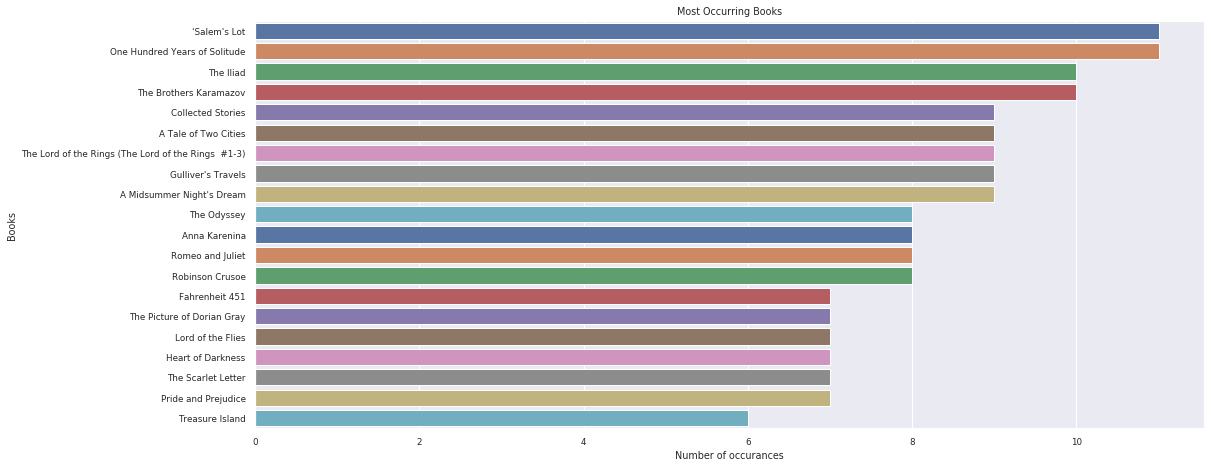

In [0]:
plt.figure(figsize=(17,7.5))
books = df['title'].value_counts()[:20]
sns.barplot(x = books, y = books.index, palette='deep')
plt.title("Most Occurring Books")
plt.xlabel("Number of occurances")
plt.ylabel("Books")
plt.show()

#**Visualisasi #2**: *WordCloud - Authors with Most Books*

> **What** : Visualisasi ini menunjukkan Kemunculan Tersering seorang Penulis (Dalam menuliskan Buku) 

> **Why** : Semakin besar Bag of Word dalam Word Cloud artinya semakin banyak buku dari Penulis tersebu

> **Who** : Target visualisasi ini adalah Pembaca Awam 

> **How** : Pre-Process 1 (Getting Only First Author) -> Make Bag of Word DataFrame -> WordCloud (Authors)

> **Analysis** : Bag of Word terbesar adalah milik **Stephen King** dan dapat diartikan penulis tersebut berhasil menulis buku dengan berbagai judul ataupun buku dengan beragam edisi. Didapati bahwa Stephen King merupakan penulis dengan Buku terbanyak dengan 128 buku, dengan fakta ini kita bisa mencari tahu lebih dalam terkait Informasi lain yang terkandung misalkan "Bagaimana track record Stephen King dari sekian banyak buku yang ia keluarkan dari tahun ke tahun?"

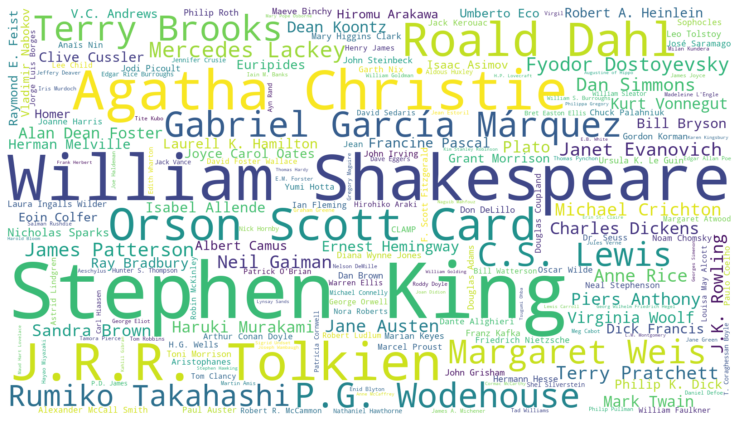

In [0]:
penulis = df.authors
penulis_count = penulis.value_counts()
df_count = pd.DataFrame(data=penulis_count) #Convert to Dataframe
bag = df_count.reset_index() #A Bag to make sure that there's a Column for Author and Value Counts

d = {}
for a, x in bag.values:
    d[a] = x

wordcloud = WordCloud(background_color='white', width=1600, height=900)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(20,7.5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#**Visualisasi #3**: *LinePlot - Spesific Authors (Stephen King) Performance throughout Year*

> **What** : Visualisasi ini menunjukkan rataan Rating dari Stephen King di tahun-tahun Buku Stephen King diluncurkan

> **Why** : Rataan Rating tiap tahunnya mencerminkan Track Record / Performance Stephen King, dipilihnya Stephen King berdasarkan Bag of Word terbesar di Visualisasi WordCloud sebelumnya 

> **Who** : Target visualisasi ini adalah Calon Pembaca Buku atau Penggemar Stephen King 

> **How** : Pre-Process 2 (Generate Year from Goodreads API) -> Line Plot (Filter Author = "Stephen King")

> **Analysis** : Dengan Jumlah Observasi Buku terbanyak dari **Stephen King**, Kita dapat melihat dari plot bahwa periode rating terbaik Stephen King adalah di tahun 1986. Track Recordnya selalu konsisten, tetapi menurun sekali di tahun sembilan puluhan dan setelah pergantian dekade baru. Ia dikenal dengan karya Rita Hayworth dan Shawshank, yang kebetulan berada dalam jangkauan terbaiknya, 1982-1987, Stephen King adalah legenda dalam tulisan yang telah ia Publikasikan.

100% (128 of 128) |######################| Elapsed Time: 0:01:50 Time:  0:01:50


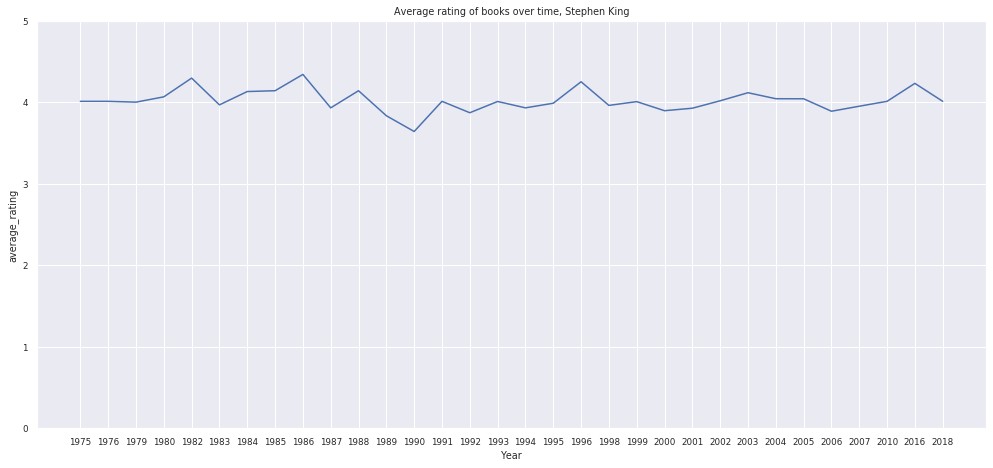

In [0]:
def plot_author_chart(author_df):
    year = bookdata(author_df)
    author_df = final_df(author_df, year)
    author_df.dropna(0, inplace=True)
    author_df = author_df[author_df['Year'].str.isnumeric()]
    author_df = author_df.set_index('title')
    author_df = author_df[author_df.Year !='0']
    plt.figure(figsize=(17,7.5))
    ax =  sns.lineplot(author_df['Year'], author_df['average_rating'], ci=None)
    sns.set(font_scale=0.8)
    plt.ylim(0, 5)
    ax.set_title("Average rating of books over time, "+ author_df.authors[1])
    return ax

author_df = df[df['authors']=='Stephen King']
plot_author_chart(author_df)

#**Visualisasi #4**: *Doughnout Chart - Rating Distribution*

> **What** : Visualisasi ini menunjukkan Persentase untuk setiap Range pemberian Rating 

> **Why** : Persentase dari masing-masing Range mencerminkan Perilaku Pengguna dalam memberi Rating

> **Who** : Target visualisasi ini adalah Goodreads

> **How** : Pre-Process 3 (Function Classify Rating Range) -> Doughnout Chart

> **Analysis** : Rating terbanyak dapat menunjukkan secara alami pengguna memberikan rating kepada buku dengan rentang 3-4 dan 4-5 yang berarti mayoritas buku yang terindeks Goodreads mampu memuaskan pembacanya. Sementara rating 0-1 yang mendapat posisi nomor 2 dari belakang dapat diartikan tidak ada orang yang memberikan rating terhadap buku tersebut.

13714


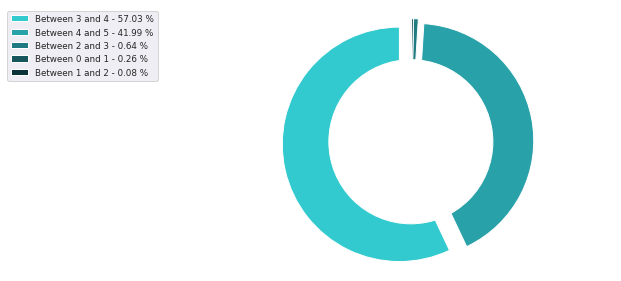

In [0]:
df['Ratings_Dist'] = segregation(df)
ratings_pie = df['Ratings_Dist'].value_counts().reset_index()
labels = ratings_pie['index']
colors = ['#32CACE','#29A1A8','#207A81','#16555C', '#0C3339'] #http://tristen.ca/hcl-picker
percent = 100.*ratings_pie['Ratings_Dist']/ratings_pie['Ratings_Dist'].sum()
fig, ax1 = plt.subplots()
ax1.pie(ratings_pie['Ratings_Dist'],colors = colors, 
        pctdistance=0.85, startangle=90, explode=(0.1, 0.05, 0.05, 0.05, 0.05))

#Draw a Circle now:
centre_circle = plt.Circle((0,0), 0.70, fc ='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)

#Equal Aspect ratio ensures that pie is drawn as a Circle
plt.axis('equal')
plt.tight_layout()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.legend( labels, loc = 'best',bbox_to_anchor=(-0.1, 1.),)

# **Visualisasi #5**: *Scatter Plot - Book Distribution based on Average Rating & Text Review*

> **What** : Visualisasi scatter plot ini menunjukkan Sebaran Buku berdasarkan rata-rata rating dengan jumlah kata dalam Review 

> **Why** : Sebaran dalam Plot ini bisa mencerminkan pola hubungan antar kedua atribut tersebut

> **Who** : Target visualisasi ini adalah Goodreads

> **How** : Scatter Plot (X=Average Rating, Y=Text Review Count) -> Scatter Plot (Filter Text Review Count<5000)

> **Analysis**: Dari Scatter berwarna Biru kita dapat menyimpulkan dari plot bahwa sebagian besar *average rating* untuk buku-buku itu tampaknya berada di range 3-4, dengan sejumlah besar *text review count* yang terletak kira-kira hampir mendekati 5000. Setelah mencoba memperjelas scatter plot dibagian tersebut dengan Scatter berwarna Hijau, Dapat diamati bahwa bahkan sekarang, sebagian besar ulasan teks untuk buku masih berada di bawah 1000. Mungkin terdapat hubungan dimana banyaknya *text review count* tampaknya dominan di antara buku-buku dengan *average rating* yang layak. Sebaliknya jumlah *text review count* sangat berkurang ketika di antara buku-buku dengan *average rating* tidak layak. Jika jumlah kata review 0 maka dapat diperkirakan jika pemberi rating tidak peduli dengan buku yang dibacanya atau mungkin saja itu adalah pemberi rating asal-asalan.

<Figure size 1224x540 with 0 Axes>

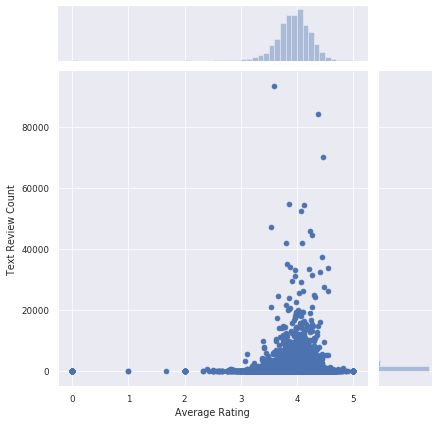

In [0]:
#Melihat hubungan antara average_rating dan text_review_count
plt.figure(figsize=(17,7.5))
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= df[['text_reviews_count', 'average_rating']])
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()

<Figure size 1080x720 with 0 Axes>

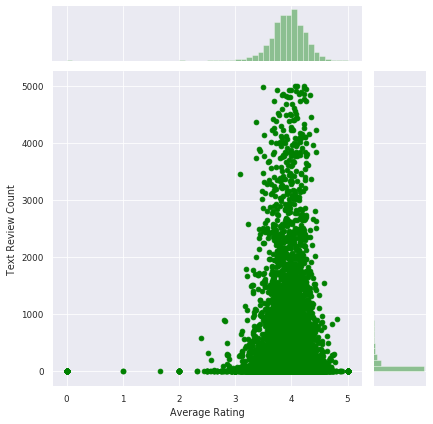

In [0]:
trial = df[~(df['text_reviews_count']>5000)]

plt.figure(figsize=(15,10))
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= trial, color = 'green')
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()